In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
IT_finance = pd.read_excel('./data/dongboo/IT_TOTAL_재무사항.xlsx')
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')

IT_validation_finance = pd.read_excel('./data/dongboo/IT_validation_재무사항.xlsx')
IT_validation_nonfinance = pd.read_excel('./data/dongboo/비재무validation/validation_비재무_it_total_최종.xlsx')

In [4]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')

IT_validation_stock = pd.read_excel('./data/dongboo/IT_validation_주가.xls')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [5]:
IT_info = pd.merge(IT_finance,IT_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_val_info = pd.merge(IT_validation_finance,IT_validation_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [6]:
IT = pd.merge(IT_info, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_val = pd.merge(IT_val_info,IT_validation_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])

In [7]:
IT_fi = pd.merge(IT_finance, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_no_fi = pd.merge(IT_nonfinance, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [8]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

# ------------- validation ------------------

samsungelectric = IT_val[IT_val['회사명'] == '삼성전자(주)']
lgelectric = IT_val[IT_val['회사명'] == '엘지전자(주)']
sds = IT_val[IT_val['회사명'] == '삼성에스디에스(주)']
lgdisplay = IT_val[IT_val['회사명'] == '엘지디스플레이(주)']

In [9]:
lg_f = IT_fi[IT_fi['회사명'] == 'LG이노텍(주)']
sdi_f = IT_fi[IT_fi['회사명'] == '삼성SDI(주)']
ssem_f = IT_fi[IT_fi['회사명'] == '삼성전기(주)']
hynix_f = IT_fi[IT_fi['회사명'] == '에스케이하이닉스(주)']


In [10]:
lg_nf = IT_no_fi[IT_no_fi['회사명'] == 'LG이노텍(주)']
sdi_nf = IT_no_fi[IT_no_fi['회사명'] == '삼성SDI(주)']
ssem_nf = IT_no_fi[IT_no_fi['회사명'] == '삼성전기(주)']
hynix_nf = IT_no_fi[IT_no_fi['회사명'] == '에스케이하이닉스(주)']

In [11]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [12]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

classify(lg_f)
classify(sdi_f)
classify(ssem_f)
classify(hynix_f)

classify(lg_nf)
classify(sdi_nf)
classify(ssem_nf)
classify(hynix_nf)

# ------------- validation ------------------

classify(samsungelectric)
classify(lgelectric)
classify(sds)
classify(lgdisplay)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,확정급여제도의 재측정요소,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,확정급여제도의 재측정요소.1,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,확정급여제도의 재측정요소.2,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),확정급여제도의 재측정요소.3,기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,확정급여제도의 재측정요소.4,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,합계,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*)

In [13]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

lg_f = lg_f.iloc[:-1,:]
sdi_f = sdi_f.iloc[:-1,:]
ssem_f = ssem_f.iloc[:-1,:]
hynix_f = hynix_f.iloc[:-1,:]

lg_nf = lg_nf.iloc[:-1,:]
sdi_nf = sdi_nf.iloc[:-1,:]
ssem_nf = ssem_nf.iloc[:-1,:]
hynix_nf = hynix_nf.iloc[:-1,:]

# ------------- validation ------------------

samsungelectric = samsungelectric.iloc[:-1,:]
lgelectric = lgelectric.iloc[:-1,:]
sds = sds.iloc[:-1,:]
lgdisplay = lgdisplay.iloc[:-1,:]

In [14]:
lg_f_corr = lg_f.corr(method = 'pearson')
df_lg_f = pd.DataFrame(lg_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg_f.columns = ['지표','3개월후종가']

sdi_f_corr = sdi_f.corr(method = 'pearson')
df_sdi_f = pd.DataFrame(sdi_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi_f.columns = ['지표','3개월후종가']

ssem_f_corr = ssem_f.corr(method = 'pearson')
df_ssem_f = pd.DataFrame(ssem_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem_f.columns = ['지표','3개월후종가']

hynix_f_corr = hynix_f.corr(method = 'pearson')
df_hynix_f = pd.DataFrame(hynix_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix_f.columns = ['지표','3개월후종가']

In [15]:
lg_nf_corr = lg_nf.corr(method = 'pearson')
df_lg_nf = pd.DataFrame(lg_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg_nf.columns = ['지표','3개월후종가']

sdi_nf_corr = sdi_nf.corr(method = 'pearson')
df_sdi_nf = pd.DataFrame(sdi_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi_nf.columns = ['지표','3개월후종가']

ssem_nf_corr = ssem_nf.corr(method = 'pearson')
df_ssem_nf = pd.DataFrame(ssem_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem_nf.columns = ['지표','3개월후종가']

hynix_nf_corr = hynix_nf.corr(method = 'pearson')
df_hynix_nf = pd.DataFrame(hynix_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix_nf.columns = ['지표','3개월후종가']

In [16]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg_f.index[:order])):
    list_corr.append(df_lg_f.index[:order][i])
    list_corr.append(df_sdi_f.index[:order][i])
    list_corr.append(df_ssem_f.index[:order][i])
    list_corr.append(df_hynix_f.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

var = []

for i in range(len(variable)):
    var.append(df_lg_f[df_lg_f.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]

corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr = corr[corr['var'] != '분기수익률'].reset_index(drop = True)
corr

,var_index,var,number
0,108,총포괄손익,4
1,366,최고가,4
2,367,최저가,4
3,59,미처분이익잉여금(결손금),4
4,368,종가,4
5,66,* (정상)영업손익(계산수치),4
6,95,당기순이익(손실),3
7,88,법인세비용차감전순이익(손실),3
8,89,법인세비용,3
9,370,거래대금,3


In [17]:
list_corr_nf = []
order = 15 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg_nf.index[:order])):
    list_corr_nf.append(df_lg_nf.index[:order][i])
    list_corr_nf.append(df_sdi_nf.index[:order][i])
    list_corr_nf.append(df_ssem_nf.index[:order][i])
    list_corr_nf.append(df_hynix_nf.index[:order][i])

variable_nf = pd.Series(list_corr_nf).value_counts()
variable_nf = pd.DataFrame(variable_nf).reset_index()
variable_nf.columns = ['var_index', 'number']

var_nf = []


for i in range(len(variable_nf)):
    var_nf.append(df_lg_nf[df_lg_nf.index == variable_nf['var_index'][i]]['지표'].values[0])
var_nf = pd.DataFrame(var_nf)
var_nf.columns = ['var']

corr_nf = pd.concat([variable_nf,var_nf], axis = 1)
corr_nf = corr_nf[['var_index','var','number']]

corr_nf = corr_nf[corr_nf['var'] != '3개월후종가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '수익률상승하락'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '분기수익률'].reset_index(drop = True)


corr_nf = corr_nf[corr_nf['var'] != '거래대금'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '종가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '최저가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '최고가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '거래량'].reset_index(drop = True)
corr_nf

,var_index,var,number
0,20,합계_평균근속연수,4
1,12,기간제_기말인원(남)(명),3
2,14,기간제_기말인원(명),3
3,15,합계_기말인원_남(명),3
4,17,합계_기말인원(명),3
5,16,합계_기말인원_여(명),2
6,13,기간제_기말인원(여)(명),2
7,11,정규+무기계약_기말인원(명),2
8,10,정규+무기계약_기말인원(여)(명),2
9,9,정규+무기계약_기말인원(남)(명),2


In [18]:
corr = pd.concat([corr[:10],corr_nf[:10]],axis = 0).reset_index(drop = True)

In [19]:
deep_lg = lg[corr['var'][:20]]
deep_sdi = sdi[corr['var'][:20]]
deep_ssem = ssem[corr['var'][:20]]
deep_hynix = hynix[corr['var'][:20]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

deep_lg = deep_lg.dropna(axis = 0)
deep_ssem = deep_ssem.dropna(axis = 0)
deep_sdi = deep_sdi.dropna(axis = 0)
deep_hynix = deep_hynix.dropna(axis = 0)
# ------------ validation --------------

deep_samsungelectric = samsungelectric[corr['var'][0:20]]
deep_lgelectric = lgelectric[corr['var'][0:20]]
deep_sds = sds[corr['var'][0:20]]
deep_lgdisplay = lgdisplay[corr['var'][0:20]]

deep_samsungelectric['수익률상승하락'] = samsungelectric['수익률상승하락']
deep_lgelectric['수익률상승하락'] = lgelectric['수익률상승하락']
deep_sds['수익률상승하락'] = sds['수익률상승하락']
deep_lgdisplay['수익률상승하락'] = lgdisplay['수익률상승하락']

deep_samsungelectric = deep_samsungelectric.dropna(axis = 0)
deep_lgelectric = deep_lgelectric.dropna(axis = 0)
deep_sds = deep_sds.dropna(axis = 0)
deep_lgdisplay = deep_lgdisplay.dropna(axis = 0)

In [20]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# ------------ validation --------------

scaler_samsungelectric = StandardScaler()
scale_samsungelectric = pd.DataFrame(scaler_lg.fit_transform(deep_samsungelectric.iloc[:,:-1]))

scaler_lgelectric = StandardScaler()
scale_lgelectric = pd.DataFrame(scaler_sdi.fit_transform(deep_lgelectric.iloc[:,:-1]))

scaler_sds = StandardScaler()
scale_sds = pd.DataFrame(scaler_ssem.fit_transform(deep_sds.iloc[:,:-1]))

scaler_lgdisplay = StandardScaler()
scale_lgdisplay = pd.DataFrame(scaler_hynix.fit_transform(deep_lgdisplay.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [21]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

# ------------ validation --------------

# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT_validation = pd.concat([deep_samsungelectric,deep_lgelectric,deep_sds,deep_lgdisplay], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT_validation = pd.concat([scale_samsungelectric,scale_lgelectric,scale_sds,scale_lgdisplay], ignore_index=True)

In [22]:
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc
# import seaborn as sns
# import matplotlib
# font_location = "c:/Windows/fonts/malgun.ttf"
# font_name = font_manager.FontProperties(fname=font_location).get_name()
# matplotlib.rc('font', family=font_name)

In [23]:
# plt.figure(figsize=(20,50))

# sns.heatmap(data = scale_IT.corr(), annot = True)
# # plt.savefig('tmp.png')

# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [24]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [25]:
# 히든레이어 1개 짜리!!!!

# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()

deep_IT = pd.concat([deep_hynix,deep_ssem,deep_sdi,deep_lg], ignore_index=True)
scale_IT = pd.concat([scale_hynix,scale_ssem,scale_sdi,scale_lg], ignore_index=True)

x_data = scale_IT
y_data = deep_IT.iloc[:,[-1]]


graph_cost = []
graph_acc = []

# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 1], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([1]))

hypothesis = tf.sigmoid(tf.matmul(X, W1) + b1)


# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [26]:
# # 히든레이어 5개 짜리!!!

# # Review : Learning rate and Evaluation
# import tensorflow as tf
# import random
# import matplotlib.pyplot as plt

# tf.set_random_seed(777)  # reproducibility
# tf.reset_default_graph()


# x_data = scale_IT
# y_data = deep_IT.iloc[:,[-1]]


# # parameters
# placeholder_num = len(x_data.columns)
# learning_rate = 0.0001




# X = tf.placeholder(tf.float32, [None, placeholder_num])
# Y = tf.placeholder(tf.float32, [None, 1])
# keep_prob = tf.placeholder(tf.float32)


# W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
# b1 = tf.Variable(tf.random_normal([32]))
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
# L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


# W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
# b2 = tf.Variable(tf.random_normal([64]))
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
# L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
# b3 = tf.Variable(tf.random_normal([64]))
# L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
# L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


# W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
# b4 = tf.Variable(tf.random_normal([32]))
# L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
# L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


# W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
# b5 = tf.Variable(tf.random_normal([1]))
# L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# # hypothesis = tf.matmul(L4, W5) + b5

# # define cost/loss & optimizer

# # Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
# hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# # cost/loss function
# cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
#                        tf.log(1 - hypothesis))

# train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# # train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# # Accuracy computation
# # True if hypothesis>0.5 else False
# predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
# accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# <span style="color:red"> 가치주로 validation

In [27]:
# Launch graph

# validation_number = 3


#순서를 바꿔서 입력하자!



x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    
    for step in tqdm_notebook(range(100001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data_train, Y: y_data_train, keep_prob: 1.0})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data_test, Y: y_data_test, keep_prob: 1.0})
            graph_cost.append(cost_val)
            graph_acc.append(a)
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

#     for step in tqdm_notebook(range(9001)):
#         cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 1.0})       
#         if step % 200 == 0 or step < 10 :
#             h, c, a = sess.run([hypothesis, predicted, accuracy],
#                        feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})
#             graph_cost.append(cost_val)
#             graph_acc.append(a)
#             print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

    # Accuracy report
#     h, c, a = sess.run([hypothesis, predicted, accuracy],
#                        feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.9883406162261963 	 Acc : 60.00000238418579
Step : 1 	 Cost : 0.9881836175918579 	 Acc : 60.00000238418579
Step : 2 	 Cost : 0.9880267977714539 	 Acc : 60.00000238418579
Step : 3 	 Cost : 0.9878700375556946 	 Acc : 60.00000238418579
Step : 4 	 Cost : 0.9877132177352905 	 Acc : 60.00000238418579
Step : 5 	 Cost : 0.9875566363334656 	 Acc : 60.00000238418579
Step : 6 	 Cost : 0.9873999357223511 	 Acc : 60.00000238418579
Step : 7 	 Cost : 0.9872434735298157 	 Acc : 60.00000238418579
Step : 8 	 Cost : 0.9870871901512146 	 Acc : 60.00000238418579
Step : 9 	 Cost : 0.9869308471679688 	 Acc : 60.00000238418579
Step : 200 	 Cost : 0.9585502743721008 	 Acc : 51.99999809265137
Step : 400 	 Cost : 0.9315367341041565 	 Acc : 51.99999809265137
Step : 600 	 Cost : 0.9068053960800171 	 Acc : 51.99999809265137
Step : 800 	 Cost : 0.8840358853340149 	 Acc : 56.00000023841858
Step : 1000 	 Cost : 0.8630115389823914 	 Acc : 56.00000023841858
Step : 1200 	 Cost : 0.8435768485069275 	 Ac

Step : 22800 	 Cost : 0.5796751379966736 	 Acc : 56.00000023841858
Step : 23000 	 Cost : 0.5793583989143372 	 Acc : 56.00000023841858
Step : 23200 	 Cost : 0.5790446996688843 	 Acc : 56.00000023841858
Step : 23400 	 Cost : 0.578734278678894 	 Acc : 56.00000023841858
Step : 23600 	 Cost : 0.5784267783164978 	 Acc : 56.00000023841858
Step : 23800 	 Cost : 0.5781223177909851 	 Acc : 56.00000023841858
Step : 24000 	 Cost : 0.5778207778930664 	 Acc : 56.00000023841858
Step : 24200 	 Cost : 0.5775220990180969 	 Acc : 56.00000023841858
Step : 24400 	 Cost : 0.577226459980011 	 Acc : 56.00000023841858
Step : 24600 	 Cost : 0.5769334435462952 	 Acc : 56.00000023841858
Step : 24800 	 Cost : 0.5766431093215942 	 Acc : 56.00000023841858
Step : 25000 	 Cost : 0.5763555765151978 	 Acc : 56.00000023841858
Step : 25200 	 Cost : 0.5760706663131714 	 Acc : 56.00000023841858
Step : 25400 	 Cost : 0.5757883787155151 	 Acc : 56.00000023841858
Step : 25600 	 Cost : 0.5755085945129395 	 Acc : 56.000000238418

Step : 47200 	 Cost : 0.5548291206359863 	 Acc : 63.999998569488525
Step : 47400 	 Cost : 0.554695188999176 	 Acc : 63.999998569488525
Step : 47600 	 Cost : 0.5545617341995239 	 Acc : 63.999998569488525
Step : 47800 	 Cost : 0.5544291138648987 	 Acc : 63.999998569488525
Step : 48000 	 Cost : 0.5542972683906555 	 Acc : 63.999998569488525
Step : 48200 	 Cost : 0.5541659593582153 	 Acc : 63.999998569488525
Step : 48400 	 Cost : 0.554035484790802 	 Acc : 63.999998569488525
Step : 48600 	 Cost : 0.5539056062698364 	 Acc : 63.999998569488525
Step : 48800 	 Cost : 0.5537764430046082 	 Acc : 63.999998569488525
Step : 49000 	 Cost : 0.5536478161811829 	 Acc : 63.999998569488525
Step : 49200 	 Cost : 0.553520143032074 	 Acc : 63.999998569488525
Step : 49400 	 Cost : 0.553392767906189 	 Acc : 63.999998569488525
Step : 49600 	 Cost : 0.5532662868499756 	 Acc : 63.999998569488525
Step : 49800 	 Cost : 0.5531403422355652 	 Acc : 63.999998569488525
Step : 50000 	 Cost : 0.5530150532722473 	 Acc : 63.

Step : 71200 	 Cost : 0.542579710483551 	 Acc : 63.999998569488525
Step : 71400 	 Cost : 0.5425024032592773 	 Acc : 63.999998569488525
Step : 71600 	 Cost : 0.5424254536628723 	 Acc : 63.999998569488525
Step : 71800 	 Cost : 0.5423488020896912 	 Acc : 63.999998569488525
Step : 72000 	 Cost : 0.5422725081443787 	 Acc : 63.999998569488525
Step : 72200 	 Cost : 0.54219651222229 	 Acc : 63.999998569488525
Step : 72400 	 Cost : 0.5421207547187805 	 Acc : 63.999998569488525
Step : 72600 	 Cost : 0.5420452356338501 	 Acc : 63.999998569488525
Step : 72800 	 Cost : 0.5419701337814331 	 Acc : 63.999998569488525
Step : 73000 	 Cost : 0.54189532995224 	 Acc : 63.999998569488525
Step : 73200 	 Cost : 0.5418208837509155 	 Acc : 63.999998569488525
Step : 73400 	 Cost : 0.5417467355728149 	 Acc : 63.999998569488525
Step : 73600 	 Cost : 0.5416727662086487 	 Acc : 63.999998569488525
Step : 73800 	 Cost : 0.5415989756584167 	 Acc : 63.999998569488525
Step : 74000 	 Cost : 0.5415255427360535 	 Acc : 63.9

Step : 95200 	 Cost : 0.5351476669311523 	 Acc : 63.999998569488525
Step : 95400 	 Cost : 0.5350984334945679 	 Acc : 63.999998569488525
Step : 95600 	 Cost : 0.5350493788719177 	 Acc : 63.999998569488525
Step : 95800 	 Cost : 0.5350005030632019 	 Acc : 63.999998569488525
Step : 96000 	 Cost : 0.53495192527771 	 Acc : 63.999998569488525
Step : 96200 	 Cost : 0.5349034667015076 	 Acc : 63.999998569488525
Step : 96400 	 Cost : 0.5348551869392395 	 Acc : 63.999998569488525
Step : 96600 	 Cost : 0.5348071455955505 	 Acc : 63.999998569488525
Step : 96800 	 Cost : 0.5347592234611511 	 Acc : 63.999998569488525
Step : 97000 	 Cost : 0.5347114205360413 	 Acc : 63.999998569488525
Step : 97200 	 Cost : 0.5346636772155762 	 Acc : 63.999998569488525
Step : 97400 	 Cost : 0.5346160531044006 	 Acc : 63.999998569488525
Step : 97600 	 Cost : 0.5345687866210938 	 Acc : 63.999998569488525
Step : 97800 	 Cost : 0.5345215797424316 	 Acc : 63.999998569488525
Step : 98000 	 Cost : 0.5344746112823486 	 Acc : 6

In [28]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  63.999998569488525 %


In [31]:
pd.DataFrame({'real':list(y_data_test.values.ravel()),'predict': list(c.ravel())})

,real,predict
0,1.0,1.0
1,0.0,1.0
2,0.0,0.0
3,1.0,1.0
4,1.0,0.0
5,0.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


하이닉스
18/1분기 1 / 0 (2분기를 예측)
18/2분기 1 / 0 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)

삼성전기
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sdi
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 1 / 0 (4분기를 예측)

lg전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)


1분기
없음(전부 떨어진다고 예측)

2분기
삼성sdi - 이득(실제 오름)
삼성sds - 손해(실제는 떨어짐)
lg전자 - 이득(실제 오름)

3분기
삼성전기 - 손해(실제는 떨어짐)

In [32]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

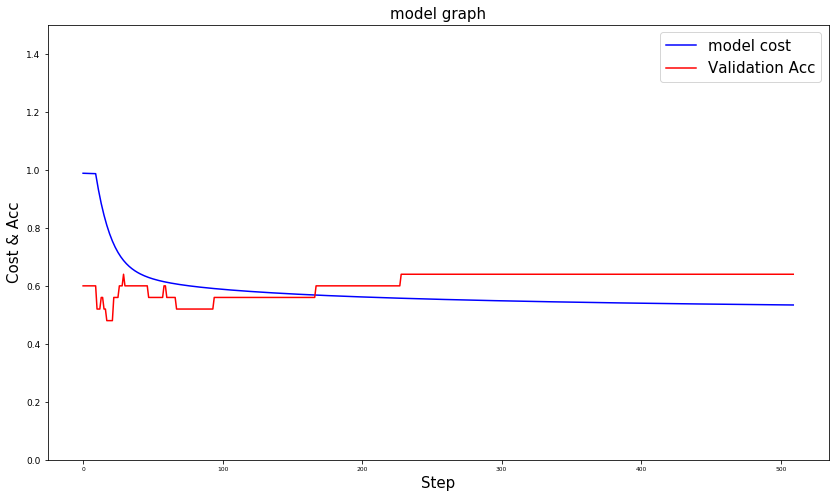

In [33]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

# <span style="color:red"> 비 가치주로 validation

In [34]:
# x_val_data = scale_sds
# y_val_data = deep_sds.iloc[:,[-1]]
x_val_data = scale_IT_validation
y_val_data = deep_IT_validation.iloc[:,[-1]]

# samsungelectric
# lgelectric
# sds
# lgdisplay

graph_cost = []
graph_acc = []

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(20001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data, Y: y_data, keep_prob: 1.0})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                               feed_dict={X: x_val_data.iloc[:,:], Y: y_val_data.iloc[:,:], keep_prob: 1.0})
            graph_cost.append(cost_val)
            graph_acc.append(a)
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    
  

Step : 0 	 Cost : 1.3343899250030518 	 Acc : 48.148149251937866
Step : 1 	 Cost : 1.33391273021698 	 Acc : 48.148149251937866
Step : 2 	 Cost : 1.3334355354309082 	 Acc : 48.148149251937866
Step : 3 	 Cost : 1.3329589366912842 	 Acc : 48.148149251937866
Step : 4 	 Cost : 1.3324823379516602 	 Acc : 48.148149251937866
Step : 5 	 Cost : 1.332006573677063 	 Acc : 48.148149251937866
Step : 6 	 Cost : 1.3315308094024658 	 Acc : 48.148149251937866
Step : 7 	 Cost : 1.3310556411743164 	 Acc : 48.148149251937866
Step : 8 	 Cost : 1.330580711364746 	 Acc : 48.148149251937866
Step : 9 	 Cost : 1.3301060199737549 	 Acc : 48.148149251937866
Step : 200 	 Cost : 1.2461395263671875 	 Acc : 49.07407462596893
Step : 400 	 Cost : 1.1717215776443481 	 Acc : 47.22222089767456
Step : 600 	 Cost : 1.1095753908157349 	 Acc : 47.22222089767456
Step : 800 	 Cost : 1.0578314065933228 	 Acc : 49.07407462596893
Step : 1000 	 Cost : 1.0145331621170044 	 Acc : 47.22222089767456
Step : 1200 	 Cost : 0.977835237979888

In [35]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  62.037038803100586 %


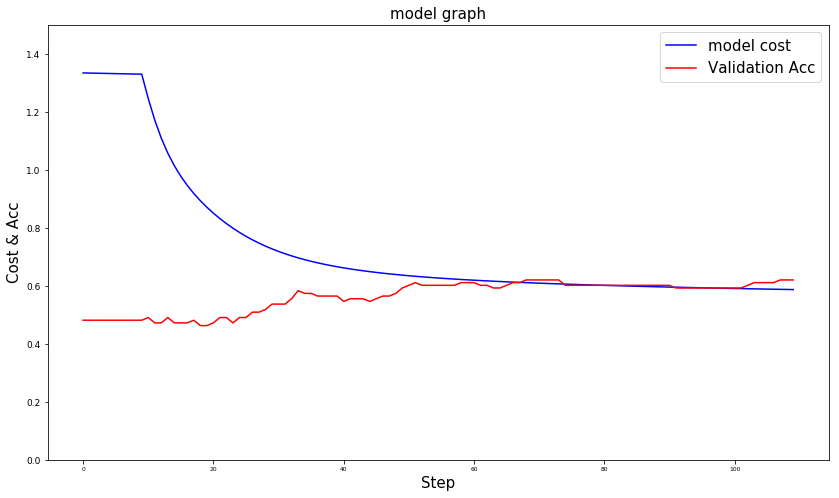

In [36]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

In [37]:
pd.DataFrame({'real':list(y_val_data.values.ravel()),'predict': list(c.ravel())})

,real,predict
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,0.0,0.0


삼성전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 0 / 1 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

lg전자
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sds
18/1분기 1 / 1 (2분기를 예측)
18/2분기 0 / 1 (3분기를 예측)
18/3분기 1 / 1 (4분기를 예측)

lg디스플레이
18/1분기 0 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 1 / 1 (4분기를 예측)


1분기
삼성sds - 이득(실제도 오름)

2분기
삼성전자 - 손해(실제는 떨어짐)
삼성sds - 손해(실제는 떨어짐)

3분기
삼성전자 - 손해(실제는 떨어짐)
lg전자 - 손해(실제는 떨어짐)
삼성sds - 이득(실제 오름)
lg디스플레이 - 이득(실제 오름)

하이닉스
18/1분기 1 / 0 (2분기를 예측)
18/2분기 1 / 0 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)

삼성전기
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sdi
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 1 / 0 (4분기를 예측)

lg전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)


1분기
없음(전부 떨어진다고 예측)

2분기
삼성sdi - 이득(실제 오름)
lg전자 - 이득(실제 오름)

3분기
삼성전기 - 손해(실제는 떨어짐)

it 8개 주식

1분기
삼성sds - 이득(실제도 오름)

2분기
삼성sdi - 이득(실제 오름)
lg전자 - 이득(실제 오름)
삼성전자 - 손해(실제는 떨어짐)
삼성sds - 손해(실제는 떨어짐)

3분기
삼성전자 - 손해(실제는 떨어짐)
lg전자 - 손해(실제는 떨어짐)
삼성sds - 이득(실제 오름)
lg디스플레이 - 이득(실제 오름)
삼성전기 - 손해(실제는 떨어짐)